In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from functools import partial
from PIL import Image

/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V


def get_energy(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T + V

def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [ ]:
@jax.jit
def update_timestep(i, opt_state, batch): #probabilmente da eliminare
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

In [ ]:
x0 = np.array([3*np.pi/7, 3*np.pi/4, 2, 0.5], dtype=np.float32)
t1= np.linspace(0, 40, num=4000, dtype=np.float32)
%time x_train = jax.device_get(solve_analytical(x0, t1)) # le cordinate q, q_dot per ogni step
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train))

CPU times: user 779 ms, sys: 32.5 ms, total: 811 ms
Wall time: 1.32 s
CPU times: user 487 ms, sys: 202 ms, total: 689 ms
Wall time: 1.65 s


In [ ]:
# replace the lagrangian with a parameteric model
# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time=None):
  state, targets = batch
  preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean(jnp.abs(preds- targets)) #MaAE

# build a neural network model
init_random_params, nn_forward_fn = stax.serial( # nel paper originale hanno usato 4*500
    stax.Dense(512),
    stax.Softplus,
    stax.Dense(512),
    stax.Softplus,
    stax.Dense(512),
    stax.Softplus,
    stax.Dense(512),
    stax.Softplus,
    
    stax.Dense(1),
)
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

In [ ]:
#questo é il nostro train_set
rng = jax.random.PRNGKey(0)
prova_batch=500
prova_perbatch=512
prova_x = jnp.concatenate([                                                               #shape(640,4)
        (jax.random.uniform(rng, (prova_batch*prova_perbatch, 2))-0.5)*2*np.pi,
        (jax.random.uniform(rng+1, (prova_batch*prova_perbatch, 2))-0.5)*20
    ], axis=1)
prova_xt = jax.device_get(jax.vmap(f_analytical)(prova_x))

In [ ]:
# questo é il nostro test set
rng = jax.random.PRNGKey(0)
prova_batch=800
prova_perbatch=35
prova_x1 = jnp.concatenate([                                                               #shape(640,4)
        (jax.random.uniform(rng+2, (prova_batch*prova_perbatch, 2))-0.5)*2*np.pi,             #voglio provare a non farli compresi tra 0 e 2 pi ma
        (jax.random.uniform(rng+3, (prova_batch*prova_perbatch, 2))-0.5)*20
    ], axis=1)
prova_xt1 = jax.device_get(jax.vmap(f_analytical)(prova_x1))

In [ ]:
def custom_init(init_params, seed=0):
    new_params = []
    rng = jax.random.PRNGKey(seed)
    i = 0
    number_layers = 4
    for l1 in init_params:
        if (len(l1)) == 0: new_params.append(()); continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1:
                #Zero init biases
                new_l1.append(jnp.zeros_like(l2))
            else:
                n = max(l2.shape)
                first = int(i == 0)
                last = int(i == number_layers - 1)
                mid = int((i != 0) * (i != number_layers - 1))
                mid *= i

                std = 1.0/np.sqrt(n)
                std *= 2.2*first + 0.58*mid + n*last

                if std == 0:
                    raise NotImplementedError("Wrong dimensions for MLP")

                new_l1.append(jax.random.normal(rng, l2.shape)*std)
                rng += 1
                i += 1

        new_params.append(new_l1)
        
    return 

_, init_params = init_random_params(rng, (-1, 4))
params_cust=custom_init(init_params)

In [ ]:
%%time
from tqdm.notebook import tqdm        

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
epoch=0
total_epochs=1000

prova_batch=500
prova_perbatch=512
init_param=params_cust

train_losses = []
test_losses = []

#opt_init, opt_update, get_params = optimizers.adam(0.00003)


exp_decay = optimizers.exponential_decay(0.003, total_epochs, 0.1)
opt_init, opt_update, get_params = optimizers.adam(exp_decay)


opt_state = opt_init(init_params)
best_loss=10e5


for epoch in tqdm(range(epoch, total_epochs)):      
  total_train_loss=0
  total_test_loss=0
  for i in range(prova_batch):
    params = get_params(opt_state)
    train_loss = loss(params, (prova_x[i*prova_perbatch:(i+1) * prova_perbatch,: ],prova_xt[i*prova_perbatch:(i+1) * prova_perbatch,: ]))
    
    total_train_loss += train_loss / prova_perbatch
    opt_state = update_derivative(i, opt_state, (prova_x[i*prova_perbatch:(i+1) * prova_perbatch,: ],prova_xt[i*prova_perbatch:(i+1) * prova_perbatch, : ]))
  
  train_losses.append(total_train_loss)
  total_test_loss = loss(params, (prova_x1,prova_xt1))
  test_losses.append(total_test_loss)
  if total_test_loss < best_loss:
    best_loss=total_test_loss
    best_params=get_params(opt_state)
  print(f"epoch={epoch}, train_loss={total_train_loss:.6f}, test_loss={total_test_loss:.6f}")
  #print(np.amax(jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_train,xt_train)-(x_train,xt_train)))

  
params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch=0, train_loss=11.325489, test_loss=11.511324
epoch=1, train_loss=11.237047, test_loss=11.464804
epoch=2, train_loss=11.231338, test_loss=11.462230
epoch=3, train_loss=11.228345, test_loss=11.459681
epoch=4, train_loss=11.224435, test_loss=11.455846
epoch=5, train_loss=11.217431, test_loss=11.448080
epoch=6, train_loss=11.194378, test_loss=11.419570
epoch=7, train_loss=11.066909, test_loss=11.234730
epoch=8, train_loss=11.451930, test_loss=11.686334
epoch=9, train_loss=11.425887, test_loss=11.667556
epoch=10, train_loss=11.412844, test_loss=11.654975
epoch=11, train_loss=11.401186, test_loss=11.642488
epoch=12, train_loss=11.387161, test_loss=11.626897
epoch=13, train_loss=11.368834, test_loss=11.606242
epoch=14, train_loss=11.338485, test_loss=11.570125
epoch=15, train_loss=11.272765, test_loss=11.489913
epoch=16, train_loss=11.135911, test_loss=11.325294
epoch=17, train_loss=10.818392, test_loss=11.064032
epoch=18, train_loss=10.759523, test_loss=11.123118
epoch=19, train_loss=1

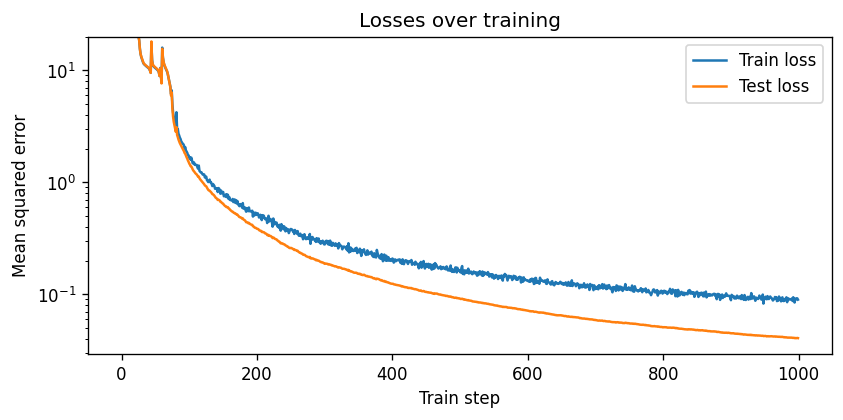

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 20)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show() #lr=0.001

In [ ]:
lost=loss(best_params, (prova_x1,prova_xt1))
print(lost)

0.42002138


In [ ]:
lost1=loss(salvato, (prova_x1,prova_xt1))
print(lost1)

0.188997


In [ ]:
import pickle as pkl
filehandler = open(b"1000epoche.obj","wb")
pkl.dump(best_params,filehandler)

In [ ]:
file = open("speriamo.obj",'rb')
salvato = pkl.load(file)

In [ ]:
from numpy import asarray
from numpy import savetxt
savetxt('allenamento1.csv', best_params, delimiter=',')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:1378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


TypeError: ignored

In [ ]:
xt_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(array_rain_fall_npy)))(x_train)

In [ ]:
# Saving array as .npy and reading it

#np.save("sclero.npy", best_params)

array_rain_fall_npy = np.load("sclero.npy",allow_pickle=True)

#print("NumPy array: \n", array_rain_fall_npy)
#print("Shape: ", array_rain_fall_npy.shape)
#print("Data Type: ", array_rain_fall_npy.dtype.name)